In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
jet = plt.cm.get_cmap("jet")
set1 = plt.cm.get_cmap("Set1")

In [2]:
def read_bin_F(name, cols=1, dtype="<f8"):
    with open(name, "rb") as f:
        data = f.read()
    data = np.frombuffer(data, dtype=np.dtype(dtype))
    if cols > 1:
        data = data.reshape(-1, cols, order="F")
    elif cols < 0:
        cols = round(data.size / abs(cols))
        data.reshape(-1, cols)
    return data

In [7]:
grilla = read_bin_F("grilla", cols=3)
Ik = read_bin_F("Ik", cols=1)
Sj = read_bin_F("Sj", cols=1)
pos = read_bin_F("pos_d", cols=3)
radii = np.linalg.norm(pos, axis=1)
mass = read_bin_F("mass_d", cols=1)
pot = read_bin_F("pot_d", cols=1)
ene = read_bin_F("ene_d", cols=1)
dens = read_bin_F("dens_d", cols=1)
hsml = read_bin_F("hsml_d", cols=1)
vel = read_bin_F("vel_d", cols=3)
boxid = read_bin_F("box_id", dtype="<i4")
ngrid3 = grilla.shape[0]
ngrid = round(ngrid3**(1/3.))
side_c = grilla[1,0] - grilla[0,0]
vol_c = side_c**3
side_g = grilla[-1,0] - grilla[0,0] + side_c
vol_g = side_g**3
npart = pos.shape[0]
top = ngrid * ngrid

In [8]:
def ijk2boxid(i, j, k, ngrid=ngrid):
    if ((i < 0) or (i >= ngrid)):
        bid = -1
    elif ((j < 0) or (j >= ngrid)):
        bid = -1
    elif ((k < 0) or (k >= ngrid)):
        bid = -1
    else:
        bid = i + j * ngrid + k * ngrid * ngrid
    return bid

def boxid2ijk(boxid, ngx=256, ngy=256, ngz=256):
    return boxid%ngx, (boxid//ngx)%ngy, boxid//(ngx*ngy)

def ijk2pos(i, j, k,
            ngx=256, ngy=256, ngz=256,
            lx=0.38, ly=0.38, lz=0.38, 
            center=[0,0,0]):
    hx = lx/ngx
    hy = ly/ngy
    hz = lz/ngz
    pos = np.asarray([(i + 0.5) * hx, (j + 0.5) * hy, (k + 0.5) * hz]) 
    off = np.asarray(center) - np.asarray([lx, ly, lz]) * 0.5
    if len(pos.shape) > 1:
        off = off[:,np.newaxis]
        return (pos + off).T
    return pos + off

def boxid2pos(boxid,
              ngx=256, ngy=256, ngz=256,
              lx=0.38, ly=0.38, lz=0.38, 
              center=[0,0,0]):
    i,j,k = boxid2ijk(boxid, ngx, ngy, ngz)
    return ijk2pos(i, j, k, ngx, ngy, ngz, lx, ly, lz, center)

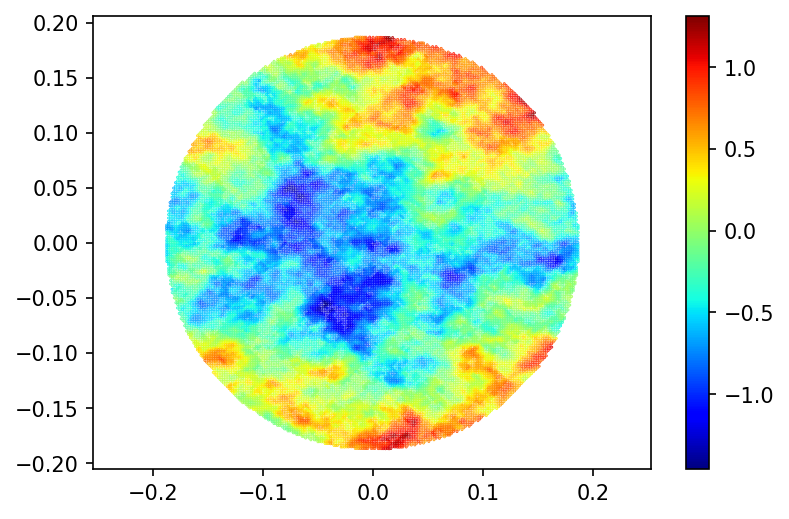

In [9]:
rnd = np.abs(pos[:,2]) < 1e-3
plt.figure(dpi=150)
scat = plt.scatter(
    pos[rnd,0], pos[rnd,1],
    c = vel[rnd,0],
    marker = ".",
    s=0.5, 
    cmap = jet,
)
plt.colorbar(scat)
plt.axis("equal")
plt.show()

In [10]:
def mode(a):
    (_, idx, counts) = np.unique(a, return_index=True, return_counts=True)
    index = idx[np.argmax(counts)]
    return a[index]

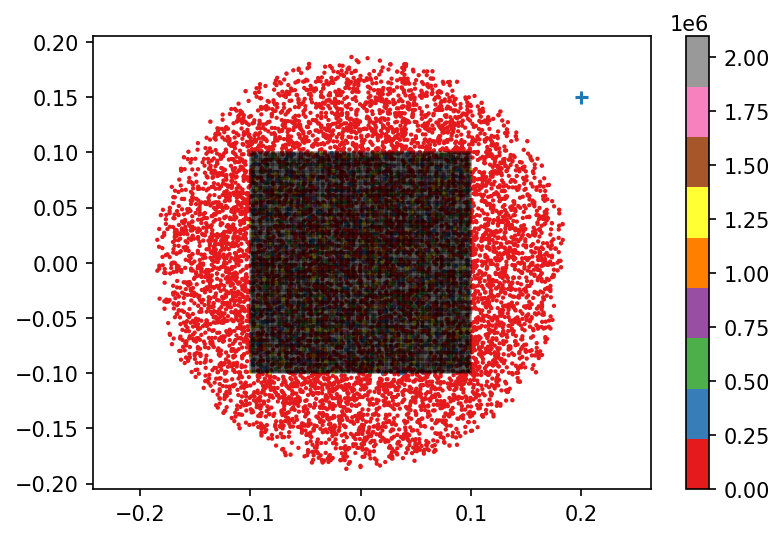

In [11]:
rnd = np.random.randint(0, npart, 10000)
mode_hsml = mode(hsml[rnd])
plt.figure(dpi=150)
scat = plt.scatter(
    pos[rnd,0], pos[rnd,1],
    c = boxid[rnd],
    marker = ".",
    s = hsml[rnd]*1000, 
    cmap = plt.cm.get_cmap("Set1"),
)
plt.colorbar(scat)
plt.vlines(0.2, 0.15-hsml.max(), 0.15+hsml.max())
plt.hlines(0.15, 0.2-hsml.max(), 0.2+hsml.max())
plt.scatter(
    grilla[:top,0], grilla[:top,1],
    s = 0.5,
    marker = "s",
    color="k",
    alpha=0.2,
)
plt.axis("equal")
plt.show()

In [12]:
values = read_bin_F("valores", cols=-ngrid3)
nextra = round(values.size / ngrid3)
vol_u = np.sum((values[:ngrid3] > 0) * vol_c)

In [35]:
dens_g = values[:ngrid3] * Ik
b = ngrid3 + ngrid3*vel.shape[1]
vel_g = values[ngrid3:b]
pot_g = values[b:b+ngrid3] * Ik
mass_g = values[b+ngrid3:b+ngrid3*2]
ene_g = values[-ngrid3:]

velx_g = vel_g[:ngrid3] * Ik
vely_g = vel_g[ngrid3:ngrid3*2] * Ik
velz_g = vel_g[ngrid3*2:] * Ik

In [36]:
np.sum(dens_g * vol_c)

14.487333463616627

In [37]:
new = np.abs(dens_g * vol_c - mass_g)

(array([6.00000e+01, 3.93600e+03, 8.35090e+04, 5.64419e+05, 5.40935e+05,
        7.97252e+05, 1.03127e+05, 3.82000e+03, 8.80000e+01, 6.00000e+00]),
 array([1.02490987e-19, 1.04015646e-19, 1.05540305e-19, 1.07064965e-19,
        1.08589624e-19, 1.10114283e-19, 1.11638942e-19, 1.13163602e-19,
        1.14688261e-19, 1.16212920e-19, 1.17737580e-19]),
 <BarContainer object of 10 artists>)

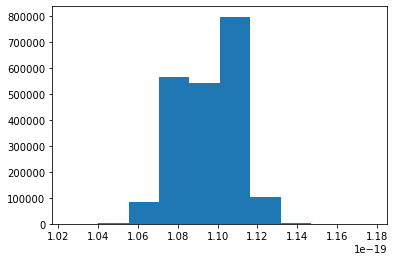

In [38]:
plt.hist(new[new>0])

In [39]:
(50/(4/3.*np.pi*0.1875**3)) / (vol_u / (np.sum(dens_g) * vol_c))

3279261.486869569

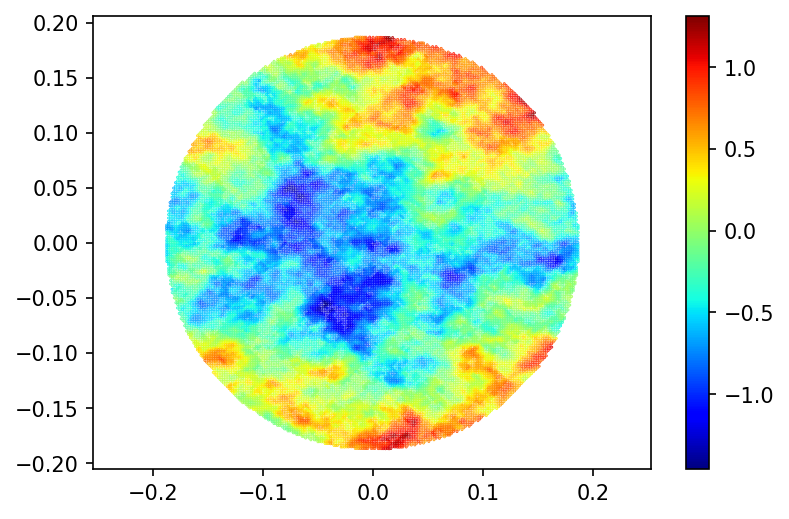

In [40]:
rnd = np.abs(pos[:,2]) < 1e-3
plt.figure(dpi=150)
scat = plt.scatter(
    pos[rnd,0], pos[rnd,1],
    c = vel[rnd,0],
    marker = ".",
    s=0.5, 
    cmap = jet,
    # vmin=-1.5,
    # vmax=1.5,
)
plt.colorbar(scat)
plt.axis("equal")
plt.show()

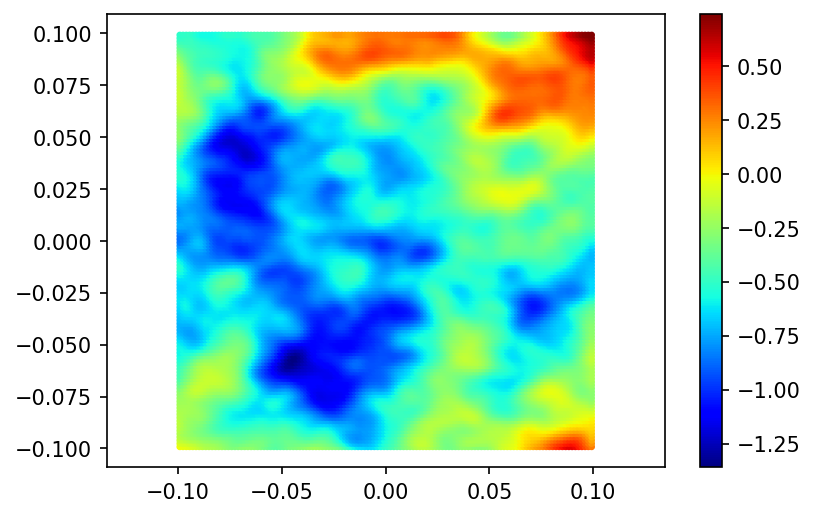

In [41]:
k = ngrid//2
bid = ijk2boxid(0, 0, k)
plt.figure(dpi=150)
scat = plt.scatter(
    grilla[:top,0], grilla[:top,1],
    c = velx_g[bid:bid+top],
    marker = "o",
    s = 5,
    cmap = jet,
    # vmin=-1.5,
    # vmax=1.5,
)
plt.colorbar(scat)
plt.axis("equal")
plt.show()

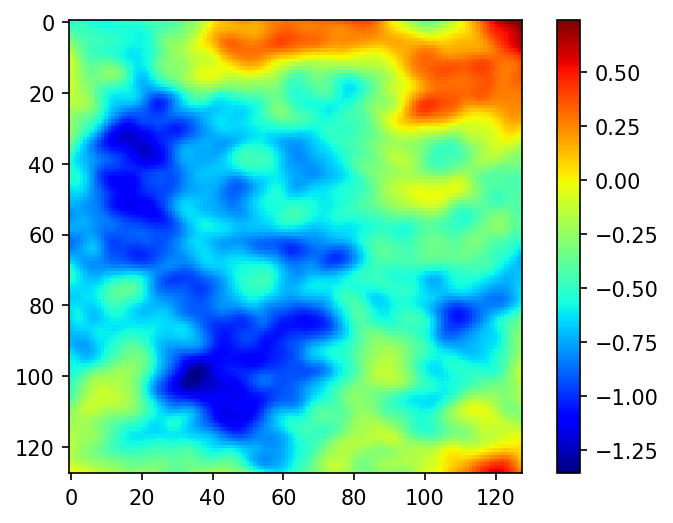

In [42]:
plt.figure(dpi=150)
plt.imshow(velx_g[bid:bid+top].reshape(ngrid, ngrid)[::-1],
           cmap=jet,
           # vmin=-1.5,
           # vmax=1.5,
          )
plt.colorbar()
plt.show()

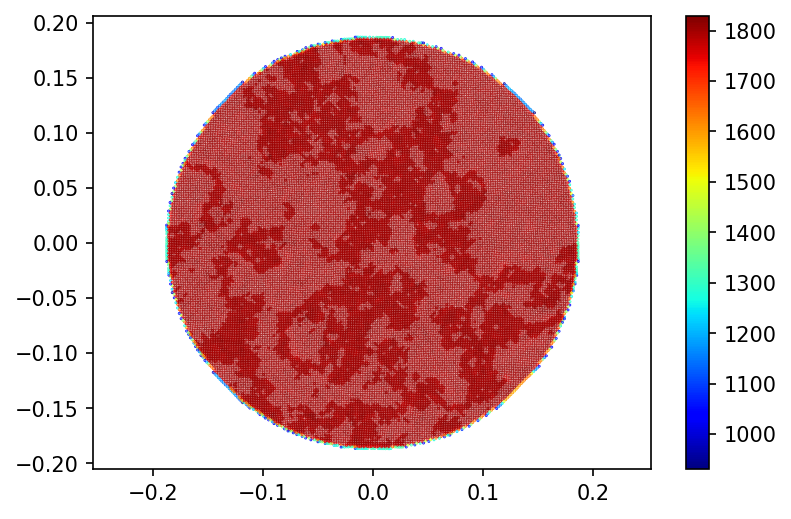

In [43]:
rnd = np.abs(pos[:,2]) < 1e-3
plt.figure(dpi=150)
scat = plt.scatter(
    pos[rnd,0], pos[rnd,1],
    c = dens[rnd],
    marker = ".",
    s=0.5, 
    cmap = jet,
    # vmin=-1.5,
    # vmax=1.5,
)
plt.colorbar(scat)
plt.axis("equal")
plt.show()

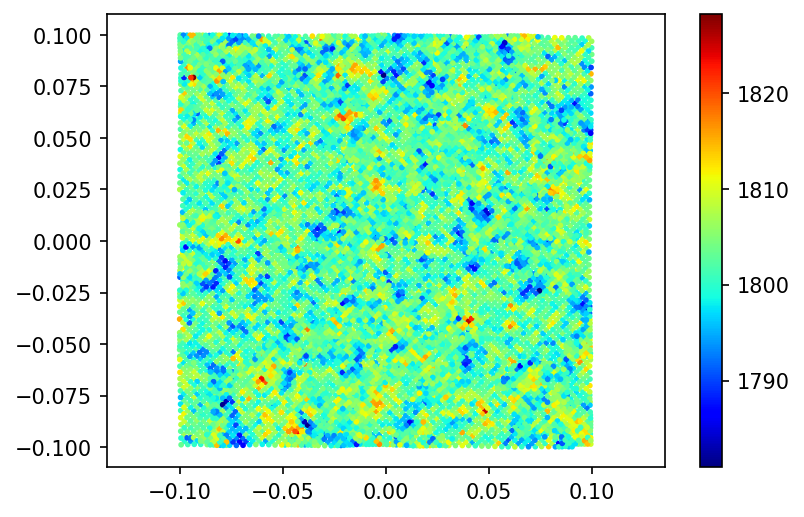

In [44]:
rnd = (np.abs(pos[:,2]) < 1e-3) & (np.abs(pos[:,0]) < side_g * 0.5) & (np.abs(pos[:,1]) < side_g * 0.5)
plt.figure(dpi=150)
scat = plt.scatter(
    pos[rnd,0], pos[rnd,1],
    c = dens[rnd],
    marker = "o",
    s=3, 
    cmap = jet,
    # vmin=-1.5,
    # vmax=1.5,
)
plt.colorbar(scat)
plt.axis("equal")
plt.show()

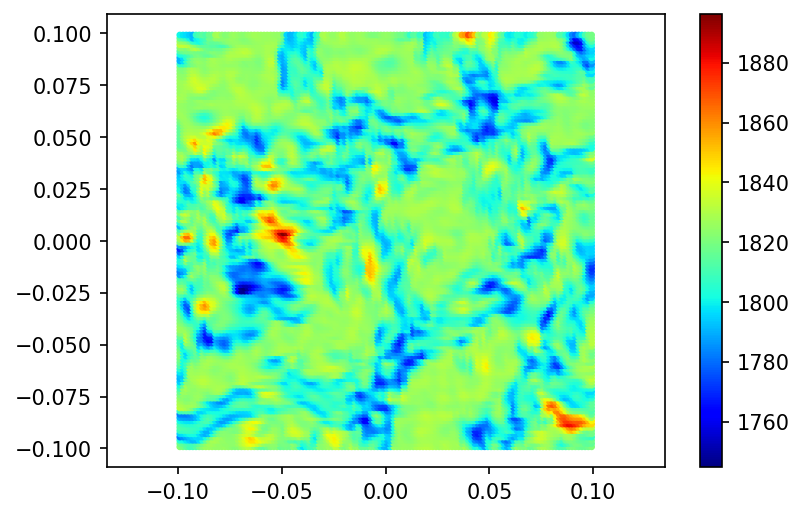

In [45]:
k = ngrid//2
bid = ijk2boxid(0, 0, k)
plt.figure(dpi=150)
scat = plt.scatter(
    grilla[:top,0], grilla[:top,1],
    c = dens_g[bid:bid+top],
    marker = "o",
    s = 5,
    cmap = jet,
    # vmin=-1.5,
    # vmax=1.5,
)
plt.colorbar(scat)
plt.axis("equal")
plt.show()

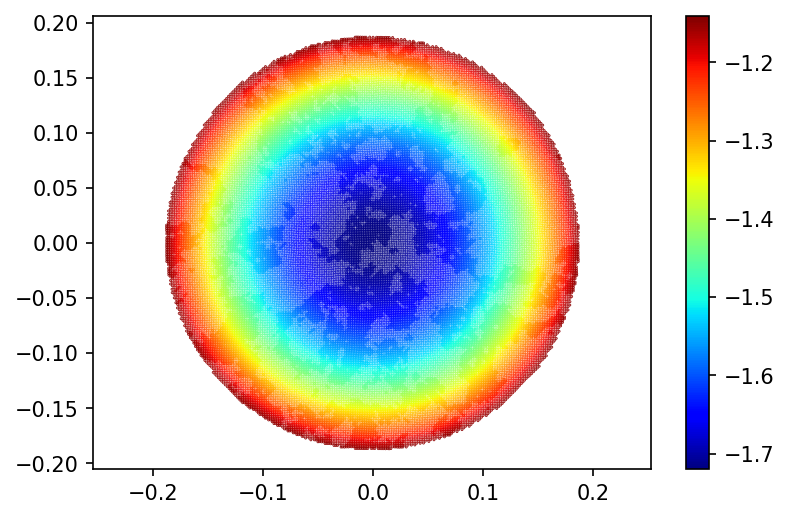

In [46]:
rnd = np.abs(pos[:,2]) < 1e-3
plt.figure(dpi=150)
scat = plt.scatter(
    pos[rnd,0], pos[rnd,1],
    c = pot[rnd],
    marker = ".",
    s=0.5, 
    cmap = jet,
    # vmin=-1.5,
    # vmax=1.5,
)
plt.colorbar(scat)
plt.axis("equal")
plt.show()

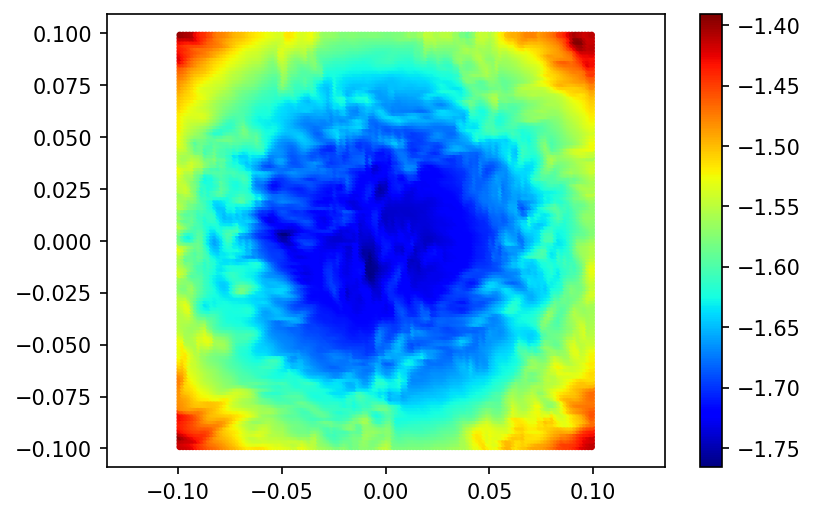

In [47]:
k = ngrid//2
bid = ijk2boxid(0, 0, k)
plt.figure(dpi=150)
scat = plt.scatter(
    grilla[:top,0], grilla[:top,1],
    c = pot_g[bid:bid+top],
    marker = "o",
    s = 5,
    cmap = jet,
    # vmin=-1.5,
    # vmax=1.5,
)
plt.colorbar(scat)
plt.axis("equal")
plt.show()

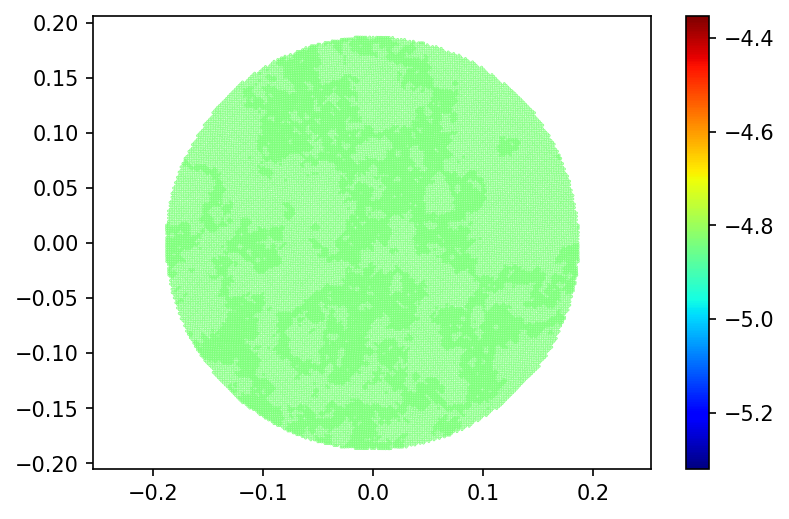

In [48]:
rnd = np.abs(pos[:,2]) < 1e-3
plt.figure(dpi=150)
scat = plt.scatter(
    pos[rnd,0], pos[rnd,1],
    c = np.log10(mass[rnd]),
    marker = ".",
    s=0.5, 
    cmap = jet,
    # vmin=-1.5,
    # vmax=1.5,
)
plt.colorbar(scat)
plt.axis("equal")
plt.show()

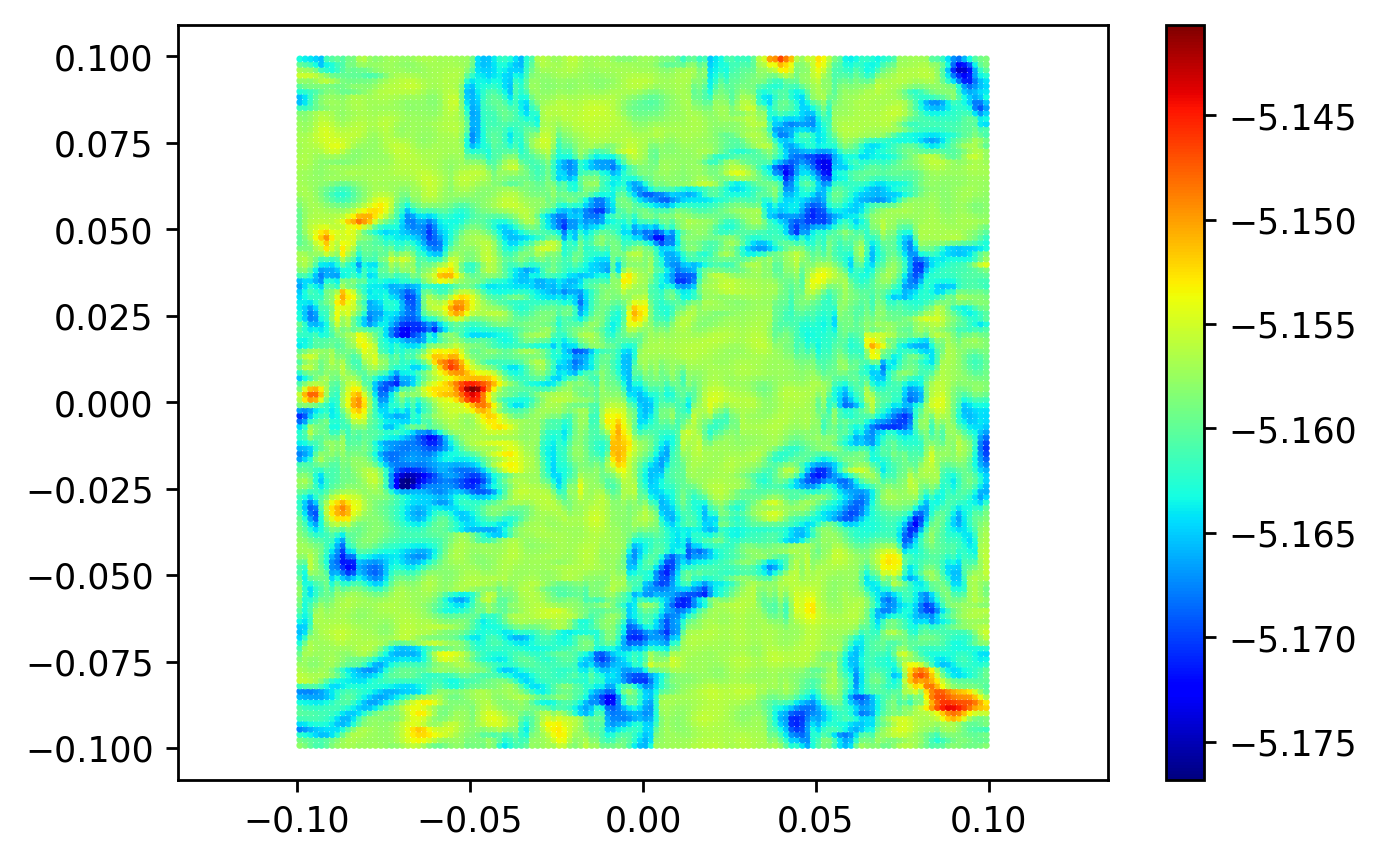

In [49]:
k = ngrid//2
bid = ijk2boxid(0, 0, k)
plt.figure(dpi=250)
scat = plt.scatter(
    grilla[:top,0], grilla[:top,1],
    c = np.log10(mass_g[bid:bid+top]),
    marker = "o",
    s = 1,
    cmap = jet,
    # vmin=-1.5,
    # vmax=1.5,
)
plt.colorbar(scat)
plt.axis("equal")
plt.show()

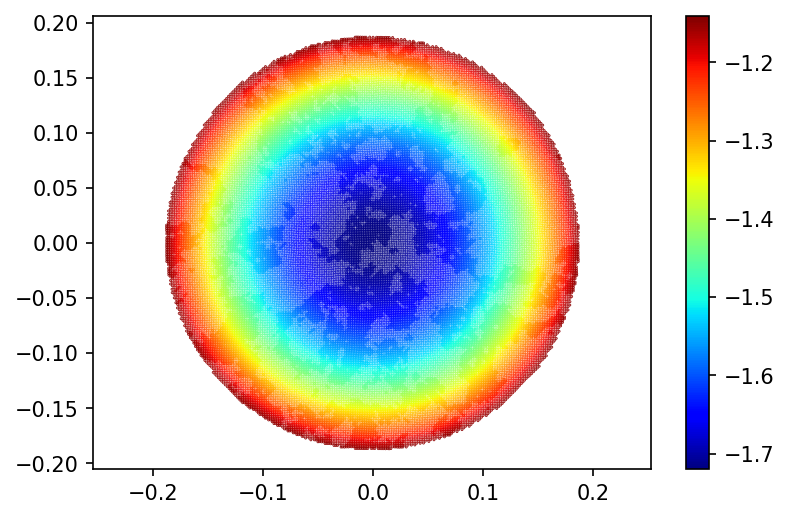

In [50]:
rnd = np.abs(pos[:,2]) < 1e-3
plt.figure(dpi=150)
scat = plt.scatter(
    pos[rnd,0], pos[rnd,1],
    c = pot[rnd],
    marker = ".",
    s=0.5, 
    cmap = jet,
    # vmin=-0.3,
    # vmax=0.3,
)
plt.colorbar(scat)
plt.axis("equal")
plt.show()

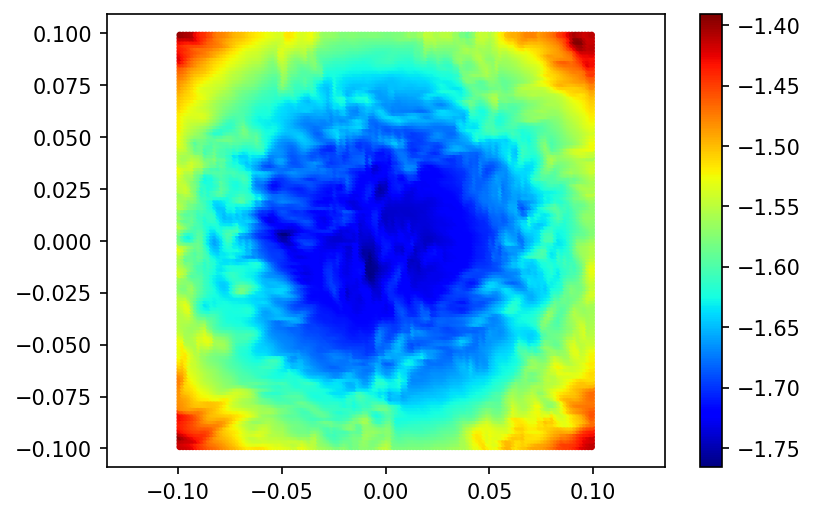

In [51]:
k = ngrid//2
bid = ijk2boxid(0, 0, k)
plt.figure(dpi=150)
scat = plt.scatter(
    grilla[:top,0], grilla[:top,1],
    c = pot_g[bid:bid+top],
    marker = "o",
    s = 5,
    cmap = jet,
    # vmin=-0.3,
    # vmax=0.3,
)
plt.colorbar(scat)
plt.axis("equal")
plt.show()

In [52]:
mass.sum()

49.999998690531356

In [53]:
mass_g.sum() / mass.sum()

0.28974667686061173

In [54]:
dens_g[dens_g>100].max() / dens[dens>100].max()

1.0367375747893883

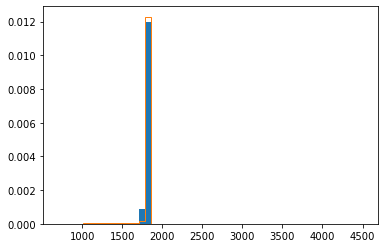

In [57]:
bins = np.linspace(700, 4500, 50)
plt.hist(dens_g[(dens_g>1) & (dens_g<2000)], bins=bins, density=True)
plt.hist(dens[dens<2000], bins=bins, density=True, histtype="step");

In [58]:
pos_g = grilla

radii_g = np.linalg.norm(pos_g, axis=1)

inc = radii_g < 0.1875

In [59]:
mass_g_c = mass_g.copy()#dens_g * vol_c

In [60]:
lim = side_g**3

In [61]:
m1b = stats.binned_statistic(radii[radii<lim], mass[radii<lim], statistic='sum', bins=30, range=None)
m2b = stats.binned_statistic(radii_g[radii_g<lim], mass_g_c[radii_g<lim], statistic='sum', bins=30, range=None)

In [62]:
rnd1 = np.random.randint(0, np.count_nonzero(inc), 3000)
rnd2 = np.random.randint(0, len(pos), 3000)

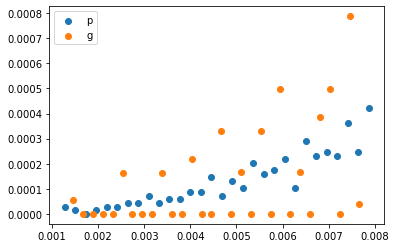

In [63]:
plt.scatter(0.5 * (m1b[1][1:] + m1b[1][:-1]), m1b[0], label="p")
plt.scatter(0.5 * (m2b[1][1:] + m2b[1][:-1]), m2b[0], label="g")
plt.legend()

In [64]:
m1b = stats.binned_statistic(radii, dens, statistic='mean', bins=30, range=None)
m2b = stats.binned_statistic(radii_g[radii_g<0.21], dens_g[radii_g<0.21], statistic='mean', bins=30, range=None)

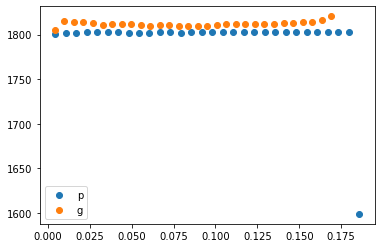

In [65]:
plt.scatter(0.5 * (m1b[1][1:] + m1b[1][:-1]), m1b[0], label="p")
plt.scatter(0.5 * (m2b[1][1:] + m2b[1][:-1]), m2b[0], label="g")
plt.legend()

In [66]:
np.sum(mass)

49.999998690531356

In [67]:
ngx = ngrid
ngy = ngrid
ngz = ngrid

In [68]:
Vx = np.asarray(np.reshape(velx_g * mass_g, (ngx, ngy, ngz), "F"), dtype="float32")
Vy = np.asarray(np.reshape(vely_g * mass_g, (ngx, ngy, ngz), "F"), dtype="float32")
Vz = np.asarray(np.reshape(velz_g * mass_g, (ngx, ngy, ngz), "F"), dtype="float32")

In [71]:
Ek = PowerSpectrum(Vx, Vy, Vz, h=side_c)

In [72]:
Pk, k, _ = stats.binned_statistic(Ek[:,0],  Ek[:,1], statistic='mean', bins=20, range=None)
k = 0.5 * (k[1:] + k[:-1])

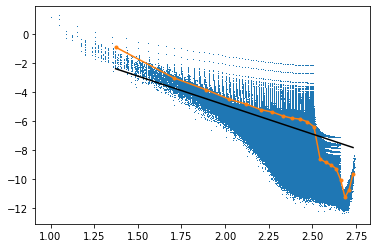

In [76]:
plt.plot(np.log10(Ek[:,0]), np.log10(Ek[:,1]), ",")
plt.plot(np.log10(k), np.log10(Pk), ".-")
plt.plot(np.log10(k), np.log10(k)*-4 + 3.1, "k-")
# plt.semilogx()
# plt.semilogy()

In [70]:
def PowerSpectrum(Vx, Vy, Vz, 
                  hx=None, hy=None, hz=None, h=1,
                  bins=None,
                  Log: bool=True, Lim=None,
                  Fit: bool=True, Verb: bool=True):
    '''Calcula el es espectro de potencias dado un campo
        3D creado por 3 matrices Vx, Vy, Vz.
    
    Parámetros:
    -----------
    Vx   : Array N-D con valores correspondientes a 
            la dirección X. (np.array [SIZE])
    Vy   : Array N-D con valores correspondientes a 
            la dirección Y. (np.array [SIZE])
    Vz   : Array N-D con valores correspondientes a 
            la dirección Z. (np.array [SIZE])
    hx   : Ancho de celda (físico) en x.
           [Opcional] (int/float; Default=1)
    hy   : Ancho de celda (físico) en y.
           [Opcional] (int/float; Default=1)
    hz   : Ancho de celda (físico) en z.
           [Opcional] (int/float; Default=1)
    h    : Ancho de celda (físico) de cualquier dirección
           no definida. 
           [Opcional] (int/float; Default=1)
    bins : Nuḿero de bines, o Bines en sí
           (límites izquierdos, último cerrado) 
           a utilizar para el binneado. 
           [Opcional] (int,list,np.ndarray; Default=None)
    Old  : Utilizar (True) o no (False) el método viejo 
           de cálculo del PS (Lento, No recomendado).
           [Opcional] (bool; Default=False)
    Log  : Si el binneado es logarítimco (True) o
           lineal (False). 
           [Opcional] (bool; Default=True)
    Lim  : Lista con límites inferior y superior de
           datos en columna principal a utilizar como
           corte.
    Fit  : Si aplicar un Fit (True) o no(False). 
           [Opcional] (bool; Default=True)
    Verb  : Imprimir en pantalla datos relevantes.
           [Opcional] (bool; Default=True)
           
    Returns:
    --------
    DataE (DataFrame), 
        Popt (np.array), Pcov (np.array) [Fit==True]
    '''
    if hx is None: hx = h
    if hy is None: hy = h
    if hz is None: hz = h
    #Ngrids y dRs
    ngx = Vx.shape[0]
    ngy = Vx.shape[1]
    ngz = Vx.shape[2]
    dx  = hx*ngx/2.
    dy  = hy*ngy/2.
    dz  = hz*ngz/2.
    #Transformamos las velocidades
    Vkx = np.fft.rfftn(Vx)
    Vky = np.fft.rfftn(Vy)
    Vkz = np.fft.rfftn(Vz)
    Vkk2 = np.abs(Vkx)**2 + np.abs(Vky)**2 + np.abs(Vkz)**2
    #Definimos las frecuencias
    KmaxX = 1/hx
    KmaxY = 1/hy
    KmaxZ = 1/hz
    KminX = 1/dx
    KminY = 1/dy
    KminZ = 1/dz
    Kmin  = np.max([KminX, KminY, KminZ])
    Kx    = np.fft.fftfreq(ngx, d=hx)
    Ky    = np.fft.fftfreq(ngy, d=hy)
    Kz    = np.fft.rfftfreq(ngz, d=hz)
    #Creamos E
    E = np.zeros((len(Kx)*len(Ky)*len(Kz),2))
    #Creamos K y VK
    KX   = np.repeat(
        np.repeat(
            Kx[:, np.newaxis], len(Kz), axis=1
            )[:, np.newaxis], ngy, axis=1)
    KY   = np.repeat(
        np.repeat(
            Ky[:, np.newaxis], len(Kz), axis=1
            )[np.newaxis, :], ngx, axis=0)
    KZ   = np.repeat(
        np.repeat(
            Kz[np.newaxis, :], ngx, axis=0
            )[:, np.newaxis], ngy, axis=1)
    KMIN = np.full(KZ.shape, Kmin)
    E[:,0] = (np.sqrt(KX**2 +
                      KY**2 +
                      KZ**2 +
                      KMIN**2)).ravel()
    E[:,1] = Vkk2.ravel()
    return E